In [1]:
!pip install roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 2.8 MB/s eta 0:00:00


**Downloading Dataset from Roboflow**

In [2]:
from roboflow import Roboflow
rf = Roboflow(api_key="XOYKZCF98ZreDPYMAWUe")
project = rf.workspace("roboflow-58fyf").project("rock-paper-scissors-sxsw")
version = project.version(14)
dataset = version.download("yolov11")
                

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to rock-paper-scissors-14 in yolov11:: 100%|██████████| 14682/14682 [00:01<00:00, 8614.80it/s] 


**Data samples**

In [3]:
import cv2
import random
import glob as glob
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(42)

In [4]:
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2] / 2, bboxes[1] - bboxes[3] / 2
    xmax, ymax = bboxes[0]+bboxes[2] / 2, bboxes[1] + bboxes[3] / 2
    return xmin, ymin, xmax, ymax

In [5]:
class_names = ['Paper', 'Rock', 'Scissors']
colors = [[0,0,255],[128,128,128],[255,0,0]]

def plot_box(image, bboxes, labels):
    
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        
        xmin = int(x1 * w)
        ymin = int(y1 * h)
        xmax = int(x2 * w)
        ymax = int(y2 * h)
        width = xmax - xmin
        height = ymax - ymin
        
        class_name = class_names[int(labels[box_num])]
        
        cv2.rectangle(
            image, 
            (xmin, ymin), (xmax, ymax),
            color=colors[class_names.index(class_name)],
            thickness=2
        ) 

        font_scale = min(1,max(3,int(w/500)))
        font_thickness = min(2, max(10,int(w/50)))
        
        p1, p2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))
       
        tw, th = cv2.getTextSize(class_name, 0, fontScale=font_scale, thickness=font_thickness)[0]
        p2 = p1[0] + tw, p1[1] + -th - 10
        cv2.rectangle(
            image, 
            p1, p2,
            color=colors[class_names.index(class_name)],
            thickness=-1,
        )
        cv2.putText(
            image, 
            class_name,
            (xmin+1, ymin-10),
            cv2.FONT_HERSHEY_SIMPLEX,
            font_scale,
            (255, 255, 255),
            font_thickness
        )
    return image

In [6]:
def plot(image_paths, label_paths, num_samples):
    all_training_images = glob.glob(image_paths)
    all_training_labels = glob.glob(label_paths)
    all_training_images.sort()
    all_training_labels.sort()
    
    num_images = len(all_training_images)
    
    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        image = cv2.imread(all_training_images[j])
        with open(all_training_labels[j], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0]
                bbox_string = label_line[2:]
                x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=0)
    plt.tight_layout()
    plt.show()

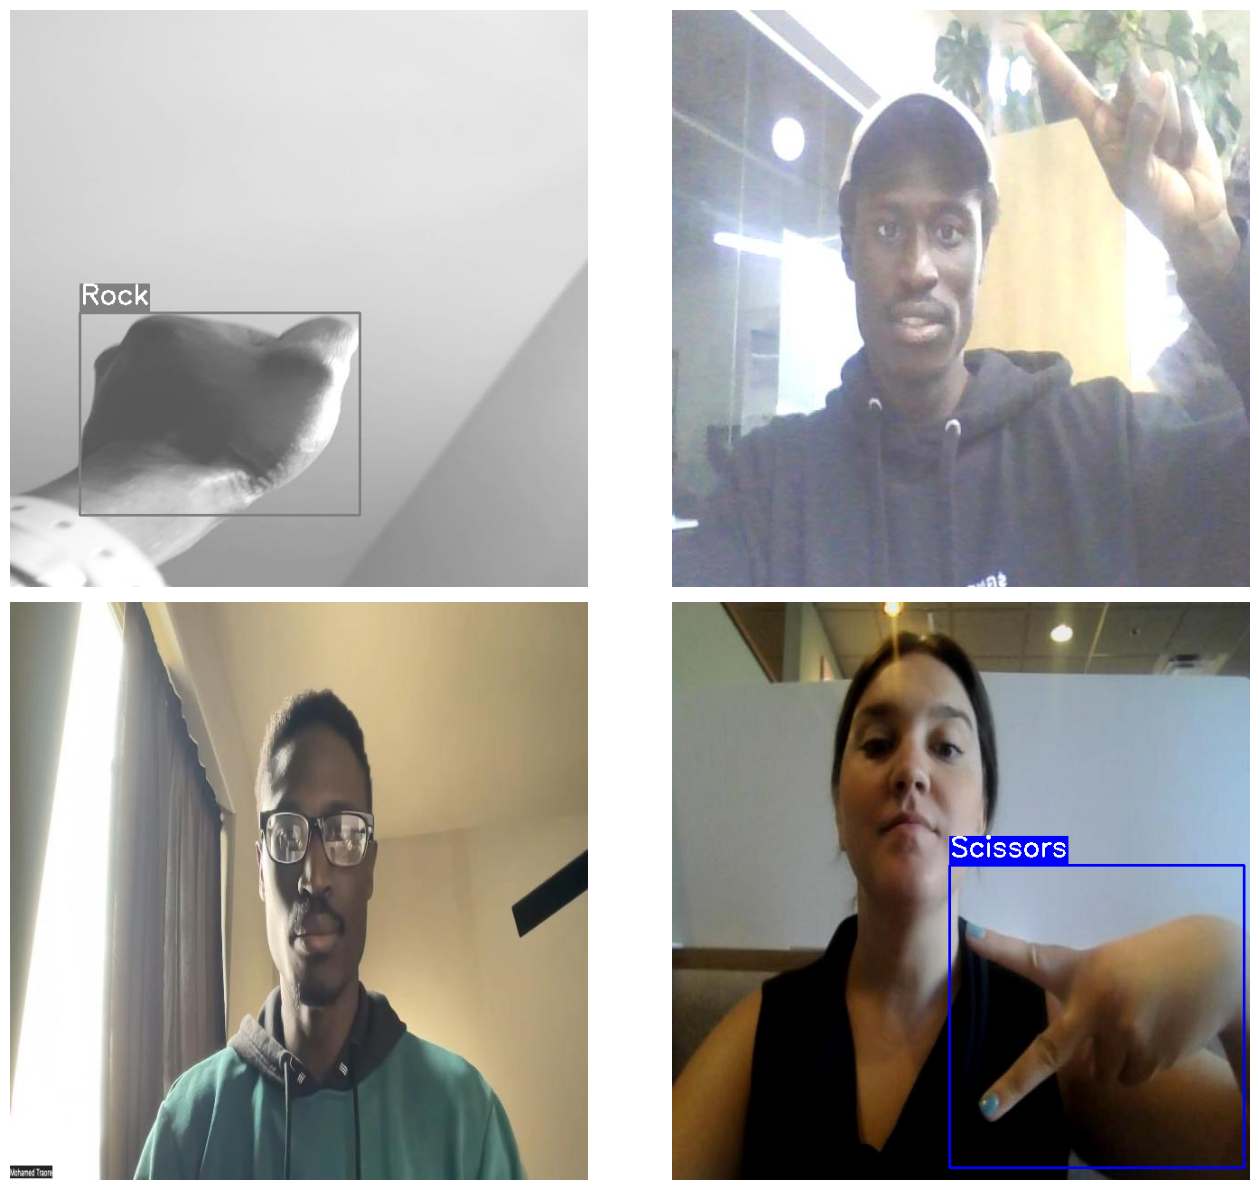

In [7]:
plot(image_paths='/kaggle/working/rock-paper-scissors-14/train/images/*',
    label_paths='/kaggle/working/rock-paper-scissors-14/train/labels/*',
    num_samples=4,
)

**Apply YOLOV11**

In [8]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.8/883.8 kB 23.4 MB/s eta 0:00:0000:01


In [9]:
from ultralytics import YOLO

model = YOLO("yolo11n.pt")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 5.35M/5.35M [00:00<00:00, 109MB/s]


In [10]:
results = model.train(data="/kaggle/working/rock-paper-scissors-14/data.yaml", epochs=50)  


Ultralytics 8.3.29 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/kaggle/working/rock-paper-scissors-14/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True

100%|██████████| 755k/755k [00:00<00:00, 20.1MB/s]
2024-11-12 11:11:12,848	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-11-12 11:11:13,715	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /kaggle/working/rock-paper-scissors-14/train/labels... 6455 images, 2516 backgrounds, 0 corrupt: 100%|██████████| 6455/6455 [00:04<00:00, 1293.81it/s]


train: New cache created: /kaggle/working/rock-paper-scissors-14/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


A new version of Albumentations is available: 1.4.21 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
val: Scanning /kaggle/working/rock-paper-scissors-14/valid/labels... 576 images, 238 backgrounds, 0 corrupt: 100%|██████████| 576/576 [00:00<00:00, 1525.15it/s]

val: New cache created: /kaggle/working/rock-paper-scissors-14/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.65G      1.304      3.201      1.476          8        640: 100%|██████████| 404/404 [01:30<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  4.19it/s]


                   all        576        400      0.482      0.544      0.485      0.296

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.64G      1.378      2.211      1.487         12        640: 100%|██████████| 404/404 [01:26<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.36it/s]

                   all        576        400      0.537      0.482      0.483      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.64G      1.413       1.96      1.504          6        640: 100%|██████████| 404/404 [01:25<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.32it/s]

                   all        576        400      0.781      0.427      0.552      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.64G      1.355      1.757      1.466          8        640: 100%|██████████| 404/404 [01:24<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.45it/s]

                   all        576        400      0.737      0.646      0.713      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.64G      1.296      1.602      1.424         11        640: 100%|██████████| 404/404 [01:24<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.63it/s]

                   all        576        400      0.719      0.636       0.71      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.64G      1.247      1.458      1.385          3        640: 100%|██████████| 404/404 [01:24<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.47it/s]

                   all        576        400      0.819      0.745      0.823      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.64G      1.197      1.387      1.357          8        640: 100%|██████████| 404/404 [01:24<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.66it/s]

                   all        576        400       0.77      0.755      0.838      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.64G      1.177      1.284      1.328         14        640: 100%|██████████| 404/404 [01:24<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.61it/s]

                   all        576        400      0.831      0.791      0.848      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.64G      1.148      1.244      1.312          6        640: 100%|██████████| 404/404 [01:24<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.62it/s]

                   all        576        400       0.85       0.76      0.862      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.64G      1.124      1.206      1.302          6        640: 100%|██████████| 404/404 [01:24<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.81it/s]

                   all        576        400      0.832      0.864      0.889      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.64G      1.095       1.14      1.282         13        640: 100%|██████████| 404/404 [01:24<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.51it/s]

                   all        576        400       0.87      0.818      0.897      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.64G      1.072      1.071      1.268          7        640: 100%|██████████| 404/404 [01:24<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.65it/s]

                   all        576        400      0.893       0.84      0.917       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.64G      1.056      1.044      1.253         16        640: 100%|██████████| 404/404 [01:24<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.21it/s]

                   all        576        400      0.887       0.79      0.893      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.64G      1.051      1.041       1.25         11        640: 100%|██████████| 404/404 [01:24<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.69it/s]

                   all        576        400       0.87      0.881      0.914       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.64G       1.04      1.008      1.241          5        640: 100%|██████████| 404/404 [01:24<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.60it/s]

                   all        576        400      0.867      0.858      0.911      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.64G      1.032     0.9991      1.238          6        640: 100%|██████████| 404/404 [01:25<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.50it/s]

                   all        576        400      0.878      0.859      0.897      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.64G     0.9926     0.9436       1.21          7        640: 100%|██████████| 404/404 [01:25<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.59it/s]

                   all        576        400      0.883      0.847      0.915      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.66G     0.9909     0.9244      1.205         17        640: 100%|██████████| 404/404 [01:24<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.38it/s]

                   all        576        400      0.895      0.878       0.92       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.64G     0.9687     0.8886      1.194         10        640: 100%|██████████| 404/404 [01:24<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.68it/s]

                   all        576        400      0.918      0.908      0.933      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.64G     0.9683     0.8743      1.198          9        640: 100%|██████████| 404/404 [01:24<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.62it/s]

                   all        576        400      0.885      0.888      0.927      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.64G     0.9509     0.8616      1.179         13        640: 100%|██████████| 404/404 [01:24<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.80it/s]

                   all        576        400      0.902      0.897      0.926      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.64G      0.953     0.8407      1.179          9        640: 100%|██████████| 404/404 [01:24<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.72it/s]

                   all        576        400      0.914      0.913      0.943       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.64G     0.9303     0.8325      1.165         13        640: 100%|██████████| 404/404 [01:24<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.69it/s]

                   all        576        400      0.916      0.884      0.929      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.64G     0.9176     0.8121      1.165          8        640: 100%|██████████| 404/404 [01:24<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.66it/s]

                   all        576        400      0.953      0.901      0.948       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.64G      0.913     0.8011      1.155         11        640: 100%|██████████| 404/404 [01:24<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.83it/s]

                   all        576        400      0.924      0.921       0.94      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.64G     0.9001     0.7845      1.154         12        640: 100%|██████████| 404/404 [01:24<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.84it/s]

                   all        576        400      0.947      0.905      0.939      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.64G     0.8794     0.7578      1.141          6        640: 100%|██████████| 404/404 [01:24<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.86it/s]

                   all        576        400      0.942      0.911      0.943      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.64G     0.8808     0.7427      1.142         14        640: 100%|██████████| 404/404 [01:24<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.79it/s]

                   all        576        400      0.943      0.928      0.949      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.64G     0.8588     0.7126      1.127         11        640: 100%|██████████| 404/404 [01:24<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.66it/s]

                   all        576        400      0.939      0.917      0.951      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.64G     0.8579      0.714      1.125          6        640: 100%|██████████| 404/404 [01:24<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.75it/s]

                   all        576        400      0.962        0.9      0.951      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.64G     0.8637     0.7086      1.124          8        640: 100%|██████████| 404/404 [01:24<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.81it/s]

                   all        576        400      0.942      0.938      0.947      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.64G     0.8593     0.7203      1.132          5        640: 100%|██████████| 404/404 [01:25<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.69it/s]

                   all        576        400      0.955       0.91      0.953      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.64G     0.8243     0.6854      1.108          8        640: 100%|██████████| 404/404 [01:25<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.81it/s]

                   all        576        400      0.959      0.917      0.949      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.64G     0.8282     0.6653      1.102          3        640: 100%|██████████| 404/404 [01:24<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.75it/s]

                   all        576        400      0.944      0.925      0.948      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.64G     0.8061     0.6588        1.1          7        640: 100%|██████████| 404/404 [01:25<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.79it/s]

                   all        576        400       0.95      0.918      0.952      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.64G     0.7992     0.6433      1.093          5        640: 100%|██████████| 404/404 [01:24<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.74it/s]

                   all        576        400      0.926      0.926      0.947       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.64G     0.7899     0.6441      1.091         12        640: 100%|██████████| 404/404 [01:24<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.71it/s]

                   all        576        400      0.957       0.93      0.963      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.64G     0.7845     0.6161      1.081          8        640: 100%|██████████| 404/404 [01:24<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.87it/s]

                   all        576        400      0.946      0.939      0.959       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.64G     0.7735     0.6059      1.076          4        640: 100%|██████████| 404/404 [01:24<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.95it/s]

                   all        576        400      0.955      0.934      0.961      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.64G     0.7566     0.5784      1.067          8        640: 100%|██████████| 404/404 [01:24<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.88it/s]

                   all        576        400      0.955      0.946      0.964      0.769


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.64G     0.6399     0.3798      1.006          5        640: 100%|██████████| 404/404 [01:25<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.89it/s]

                   all        576        400      0.961      0.905      0.952      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.64G       0.62     0.3584     0.9937          5        640: 100%|██████████| 404/404 [01:23<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.73it/s]

                   all        576        400      0.957      0.931      0.957      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.64G     0.6066     0.3455     0.9837          5        640: 100%|██████████| 404/404 [01:24<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.72it/s]

                   all        576        400      0.961      0.933       0.96      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.64G     0.5976     0.3355     0.9795          5        640: 100%|██████████| 404/404 [01:24<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.90it/s]

                   all        576        400      0.957      0.937      0.965       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.64G     0.5811     0.3333     0.9729          5        640: 100%|██████████| 404/404 [01:24<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.85it/s]

                   all        576        400       0.95      0.947      0.961      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.64G     0.5703     0.3211     0.9638          3        640: 100%|██████████| 404/404 [01:24<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.88it/s]

                   all        576        400      0.962      0.936      0.963      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.64G     0.5624      0.315      0.961          4        640: 100%|██████████| 404/404 [01:24<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.89it/s]

                   all        576        400      0.967      0.935      0.967      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.64G     0.5485     0.3093     0.9532          5        640: 100%|██████████| 404/404 [01:24<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.83it/s]

                   all        576        400      0.962      0.941      0.965       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.64G      0.535     0.3001     0.9423          6        640: 100%|██████████| 404/404 [01:24<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.58it/s]

                   all        576        400      0.956      0.943      0.965      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.64G      0.532     0.2959     0.9454         10        640: 100%|██████████| 404/404 [01:24<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.90it/s]

                   all        576        400      0.956      0.931      0.962      0.785



50 epochs completed in 1.230 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.29 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11n summary (fused): 238 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.27it/s]


                   all        576        400      0.957      0.943      0.965      0.789
                 Paper        132        139      0.963      0.946      0.956      0.789
                  Rock        121        141      0.935       0.95      0.967      0.773
              Scissors        116        120      0.972      0.933      0.971      0.804
Speed: 0.2ms preprocess, 2.1ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/train


**Prediction**

In [13]:
!yolo task=detect mode=predict model=/kaggle/working/runs/detect/train/weights/best.pt, source='/kaggle/working/rock-paper-scissors-14/test/images/IMG_7079_MOV-55_jpg.rf.6cc0b375cd6b10947909d8fcd139c20f.jpg'

WARNING ⚠️ argument 'model=/kaggle/working/runs/detect/train/weights/best.pt,' does not require trailing comma ',', updating to 'model=/kaggle/working/runs/detect/train/weights/best.pt'.
Ultralytics 8.3.29 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11n summary (fused): 238 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs

image 1/1 /kaggle/working/rock-paper-scissors-14/test/images/IMG_7079_MOV-55_jpg.rf.6cc0b375cd6b10947909d8fcd139c20f.jpg: 640x640 1 Paper, 11.3ms
Speed: 4.7ms preprocess, 11.3ms inference, 161.8ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


In [12]:
img_path = '/kaggle/working/runs/detect/predict11/IMG_7079_MOV-55_jpg.rf.6cc0b375cd6b10947909d8fcd139c20f.jpg'
img = plt.imread(img_path)

plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis(False)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/runs/detect/predict11/IMG_7079_MOV-55_jpg.rf.6cc0b375cd6b10947909d8fcd139c20f.jpg'